# Deep Learning Systems Project: Quantization

This notebook walks through:
1.  Building the NDArray backend (CPU & CUDA).
2.  Validating int8 quantization correctness.
3.  Benchmarking quantization performance (speed and memory).
4.  Training a model on MNIST using the quantized backend.

In [1]:
# %pip install pybind11

In [2]:
!ls

apps			   Makefile			   README.md
benchmark_quantization.py  memory_plot_cuda.png		   src
build			   memory_plot.png		   tests
CMakeLists.txt		   proj_andrew_full_backend.ipynb  train_mnist_quant.py
data			   python


In [3]:
!make

-- Found pybind11: /home/tyler/Documents/CMU/DL-Systems-Project/.venv/lib/python3.12/site-packages/pybind11/include (found version "3.0.1")
-- Found cuda, building cuda backend
Fri Nov 21 23:19:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   53C    P5             42W /  310W |     815MiB 

The make command reads the Makefile in the current directory. The Makefile contains rules that define how to build targets (like executables or libraries). For each target specified in the Makefile, make checks the timestamps of the target file and its dependencies (like .c, .cpp, or .h files). If any dependency has been modified recently, it must rebuild the target.

In [4]:
%set_env NEEDLE_USE_INT8_MATMUL 1  # set 1 to enable int8 kernel matmul, 0 to use float fallback

env: NEEDLE_USE_INT8_MATMUL=1  # set 1 to enable int8 kernel matmul, 0 to use float fallback


In [5]:
%set_env PYTHONPATH ./python
%set_env NEEDLE_BACKEND nd

env: PYTHONPATH=./python
env: NEEDLE_BACKEND=nd


In [6]:
import sys
sys.path.append('./python')

## Int8 quantization checks

These cells validate the new int8 quantization path (post-training).
They run quickly on CPU/GPU in Colab and ensure the quantized linear layer
tracks the float32 reference within a small tolerance.


In [7]:
!python3 -m pytest -v tests/test_quantization.py

]9;4;3;\============================= test session starts ==============================
platform linux -- Python 3.12.11, pytest-9.0.1, pluggy-1.6.0 -- /home/tyler/Documents/CMU/DL-Systems-Project/.venv/bin/python3
cachedir: .pytest_cache
rootdir: /home/tyler/Documents/CMU/DL-Systems-Project
plugins: anyio-4.11.0
collected 51 items                                                             

tests/test_quantization.py::test_quantize_round_trip[needle.backend_ndarray.ndarray_backend_cpu] ]9;4;1;0\PASSED [  1%]
collected 51 items                                                             _backend_cuda] 

tests/test_quantization.py::test_quantize_round_trip[needle.backend_ndarray.ndarray_backend_cpu] ]9;4;1;0\PASSED [  1%]
tests/test_quantization.py::test_quantize_round_trip[needle.backend_ndarray.ndarray_backend_cuda] ]9;4;1;1\PASSED [  3%]
tests/test_quantization.py::test_quantize_round_trip[needle.backend_ndarray.ndarray_backend_numpy] ]9;4;1;3\PASSED [  5%]
tests/test_qua

## Quantization performance benchmark

Runs a float32 vs int8 (weights) Linear forward benchmark. Adjust flags to explore other shapes.

Use `%set_env NEEDLE_USE_INT8_MATMUL 1` to enable the int8 backend matmul; 0 keeps float fallback.


In [8]:
!python3 benchmark_quantization.py --device cuda linear

Using needle backend
Backend: nd
Running Linear benchmark: batch=256, in=1024, out=4096, steps=30, device=cuda()
float32 avg: 3.282 ms
int8 avg:   3.193 ms
speedup:    1.03x

Full results: {'float32_total_s': 0.09845937900536228, 'int8_total_s': 0.09578855099971406, 'float32_avg_ms': 3.2819793001787425, 'int8_avg_ms': 3.1929516999904686, 'speedup_x': 1.027882538964977}
float32 avg: 3.282 ms
int8 avg:   3.193 ms
speedup:    1.03x

Full results: {'float32_total_s': 0.09845937900536228, 'int8_total_s': 0.09578855099971406, 'float32_avg_ms': 3.2819793001787425, 'int8_avg_ms': 3.1929516999904686, 'speedup_x': 1.027882538964977}


## Large-mode quantization benchmark

Heavier feedforward-style run (two Linear layers). Adjust flags for size/steps.


In [9]:
!python3 benchmark_quantization.py --device cuda mlp

Using needle backend
Backend: nd
Running MLP benchmark: batch=512, in=4096, hidden=4096, out=4096, steps=20, device=cuda()
float32 avg: 47.946 ms
int8 avg:   48.056 ms
speedup:    1.00x

Full results: {'float32_total_s': 0.9589151469990611, 'int8_total_s': 0.9611165860114852, 'float32_avg_ms': 47.945757349953055, 'int8_avg_ms': 48.05582930057426, 'speedup_x': 0.9977094984682766}
float32 avg: 47.946 ms
int8 avg:   48.056 ms
speedup:    1.00x

Full results: {'float32_total_s': 0.9589151469990611, 'int8_total_s': 0.9611165860114852, 'float32_avg_ms': 47.945757349953055, 'int8_avg_ms': 48.05582930057426, 'speedup_x': 0.9977094984682766}


## Quantization memory

Runs the memory comparison script across multiple layer sizes and saves a plot.


Using needle backend
Backend: nd
Running Memory benchmark (Actual Process Memory): in=1024, out=4096, device=cpu()
Running Memory benchmark (Actual Process Memory): in=1024, out=4096, device=cpu()
Layer: Linear(1024, 4096)
Float32 memory usage: 41.35 MB
Int8 memory usage:    12.14 MB
Memory reduction:     70.63%
Plotting sizes: [256, 512, 1024, 2048, 4096]
Layer: Linear(1024, 4096)
Float32 memory usage: 41.35 MB
Int8 memory usage:    12.14 MB
Memory reduction:     70.63%
Plotting sizes: [256, 512, 1024, 2048, 4096]
Float32 memory (MB): [1.15, 3.28, 12.46, 50.33, 75.54]
Int8 memory (MB):    [0.72, 1.59, 3.68, 11.73, 40.23]
Reduction:           ['36.8%', '51.6%', '70.5%', '76.7%', '46.7%']
Float32 memory (MB): [1.15, 3.28, 12.46, 50.33, 75.54]
Int8 memory (MB):    [0.72, 1.59, 3.68, 11.73, 40.23]
Reduction:           ['36.8%', '51.6%', '70.5%', '76.7%', '46.7%']
Saved plot to memory_plot.png
Saved plot to memory_plot.png


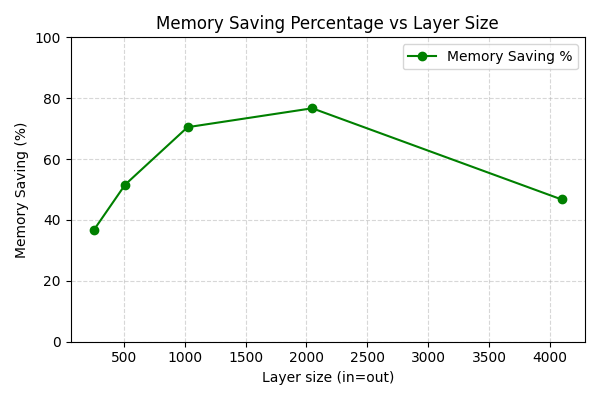

Using needle backend
Backend: nd
Running Memory benchmark (Actual GPU Memory): in=1024, out=4096, device=cuda()
Warming up CUDA context...
Running Memory benchmark (Actual GPU Memory): in=1024, out=4096, device=cuda()
Warming up CUDA context...
Layer: Linear(1024, 4096)
Float32 memory usage: 25.17 MB
Int8 memory usage:    10.49 MB
Memory reduction:     58.33%
Plotting sizes: [256, 512, 1024, 2048, 4096]
Layer: Linear(1024, 4096)
Float32 memory usage: 25.17 MB
Int8 memory usage:    10.49 MB
Memory reduction:     58.33%
Plotting sizes: [256, 512, 1024, 2048, 4096]
Float32 memory (MB): [2.1, 4.19, 8.39, 20.97, 79.69]
Int8 memory (MB):    [2.1, 2.1, 2.1, 8.39, 25.17]
Reduction:           ['0.0%', '50.0%', '75.0%', '60.0%', '68.4%']
Float32 memory (MB): [2.1, 4.19, 8.39, 20.97, 79.69]
Int8 memory (MB):    [2.1, 2.1, 2.1, 8.39, 25.17]
Reduction:           ['0.0%', '50.0%', '75.0%', '60.0%', '68.4%']
Saved plot to memory_plot_cuda.png
Saved plot to memory_plot_cuda.png


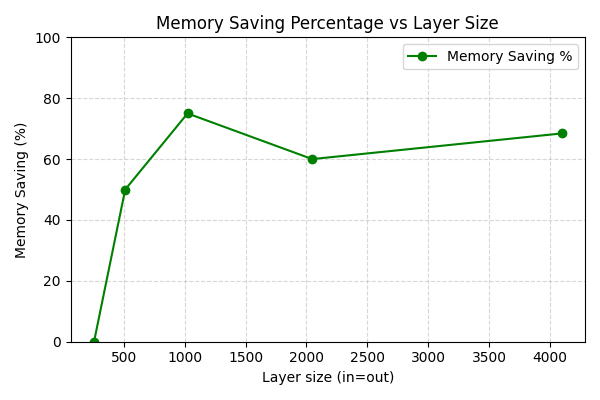

In [10]:
from IPython.display import Image, display
!python3 benchmark_quantization.py memory --save memory_plot.png
display(Image('memory_plot.png'))
!python3 benchmark_quantization.py --device cuda memory --save memory_plot_cuda.png
display(Image('memory_plot_cuda.png'))

## MNIST float vs int8 training demo

Trains a small MLP on MNIST, then reports float32 and quantized-weight accuracy.


In [11]:
!python3 train_mnist_quant.py --epochs 5 --batch-size 256 --lr 0.01 --hidden 512

Using needle backend
[float32] Epoch 1: loss=1.4690
[float32] Epoch 1: loss=1.4690
[float32] Epoch 2: loss=0.7269
[float32] Epoch 2: loss=0.7269
[float32] Epoch 3: loss=0.5519
[float32] Epoch 3: loss=0.5519
[float32] Epoch 4: loss=0.4746
[float32] Epoch 4: loss=0.4746
[float32] Epoch 5: loss=0.4296
[float32] Epoch 5: loss=0.4296
Quantizing model...
Quantizing model...
Float32 accuracy: 89.64%
Int8 (weights) accuracy: 89.15%
Float32 params: 407,050, approx memory: 1.628 MB
Int8 weight memory (with scale/zp + bias): 0.411 MB
Eval times: float=0.88s | int8=0.96s
Float32 accuracy: 89.64%
Int8 (weights) accuracy: 89.15%
Float32 params: 407,050, approx memory: 1.628 MB
Int8 weight memory (with scale/zp + bias): 0.411 MB
Eval times: float=0.88s | int8=0.96s
